In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import register_matplotlib_converters
import plotly.express as px

from factor_estimator import *
from asset_allocation import AssetAllocation
from diversification_analyzer import *
from index_data_handler import IndexDataHandler


from IPython.display import display

pd.options.mode.chained_assignment = None
register_matplotlib_converters()
%matplotlib inline

Factor investing is one of the most interesting approaches to "outperform the market" if the market is a usual market cap weighted portfolio (like MSCI World, MSCI ACWI, FTSE All World or to a degree a S&P500).
When diving into the literature one finds a whole host of factors which may be valuable. The most intersting ones come from Fama and French (Size (SmB), Value (HmL), Conservative (CvA) and Robustness (RmW). There are more out there like Momentum (Carhart, 1997) or Liquidity (Pástor, Stambaugh 2003).
Since the author of this analysis is based out of Germany, the amount of different investment options is limited. Thus we keep with the following selection, where the number represents the MSCI Index code:

In [2]:
start_date="19981130"
indexHandler = IndexDataHandler(start_date=start_date)
index_codes = {**indexHandler.get_available_indices("Developed"), **indexHandler.get_available_indices("US")}
index_codes.pop("Small-Cap")
index_codes.pop("High Dividend")

display(pd.DataFrame.from_dict(index_codes))


MSCI World         Value       Quality  Multi-Factor      Momentum  \
code          990100        705130        702787        706536        703755   
region     Developed     Developed     Developed     Developed     Developed   
ISIN    IE00BJ0KDQ92  IE00BL25JM42  IE00BL25JL35  IE00BZ0PKT83  IE00BL25JP72   
vendor     Xtrackers     Xtrackers     Xtrackers       iShares     Xtrackers   
ticker           NaN           NaN           NaN           NaN           NaN   

       Low Volatility Small-Cap (Value)  
code           129896            139249  
region      Developed                US  
ISIN     IE00BL25JN58      IE00BSPLC413  
vendor      Xtrackers              SPDR  
ticker            NaN           zprv-gy

The question asked in this analysis is: **How do I mix the ETFs for the indecies** above?

In general there are two approaches for factor investing. The integrated approach uses one etf where the stocks are picked to satisfy more then one factor at a time. Those ETFs are a one-stop solution, but have significantly higher costs. Also there is currently only a very limited selection available in Germany. The most important one is [iShares Edge MSCI World Multifactor](https://www.justetf.com/de-en/etf-profile.html?isin=IE00BZ0PKT83) which is based on the WORLD DIVERSIFIED MULTI-FACTOR index.
The TER for this is 0.5% and thus its ~0.35% higher than a market neutral MSCI World and ~0.25% higher than most 'single factor ETF'

The other approach is a *index of indicies* where you mix different ETFs to target more than a single factor. The reasoning behind that is, that factors are not stable over time and it is desireable to target more than one for continuity.

In this analysis we will try to estimate the 5 factors of the Fama French 5-Factor model. Those are MKT, SMB, HML, CWA and RMW. We then try to find the most suitable combination of ETFs for our purposes.

Let's get the data first. The data is directly taking from MSCI, and is thus available for a longer range. We examine data from 1998-2020, since this is the time span with daily data available. Every point is always normalized to the 01/01/1997, so we can look at it like we invested a euro back then.

In [3]:
data = []

#start_date="20080101"
for key in index_codes.keys():
    code = index_codes[key]["code"]
    print("reading ",key)
    d = indexHandler.get_historic_stock_data(code)
    d.rename(columns={"level_eod":key}, inplace=True)
    data.append(d)

df = data[0]
for i in range(1,len(data)):
    df = df.merge(data[i], how='left',left_index=True,right_index=True)

display(df)

reading  MSCI World
reading  Value
reading  Quality
reading  Multi-Factor
reading  Momentum
reading  Low Volatility
reading  Small-Cap (Value)


MSCI World     Value   Quality  Multi-Factor  Momentum  \
date                                                                 
1998-11-30    1.000000  1.000000  1.000000      1.000000  1.000000   
1998-12-31    1.049005  1.024456  1.067599      1.066349  1.095955   
1999-01-29    1.072120  1.039514  1.107618      1.084851  1.147905   
1999-02-26    1.043749  0.999014  1.067348      1.054852  1.105298   
1999-03-31    1.087360  1.067893  1.103971      1.118971  1.140390   
...                ...       ...       ...           ...       ...   
2021-04-19    4.509694  7.452585  6.608135      9.105336  8.360865   
2021-04-20    4.466853  7.328455  6.572796      9.033044  8.292497   
2021-04-21    4.493327  7.340272  6.626074      9.111561  8.346835   
2021-04-22    4.479906  7.345768  6.596050      9.057350  8.310539   
2021-04-23    4.514060  7.355308  6.645251      9.134924  8.416070   

            Low Volatility  Small-Cap (Value)  
date                                           
1998-11-30        1.000000           1.000000  
1998-12-31        1.048357           1.040312  
1999-01-29        1.036790           1.042894  
1999-02-26        1.003339           0.956846  
1999-03-31        1.021943           0.957336  
...                    ...                ...  
2021-04-19        5.244443          12.952608  
2021-04-20        5.250516          12.628928  
2021-04-21        5.259713          12.897351  
2021-04-22        5.253132          12.810998  
2021-04-23        5.262128          13.066504  

[5326 rows x 7 columns]

To check the data and to understand, let's chart the data:

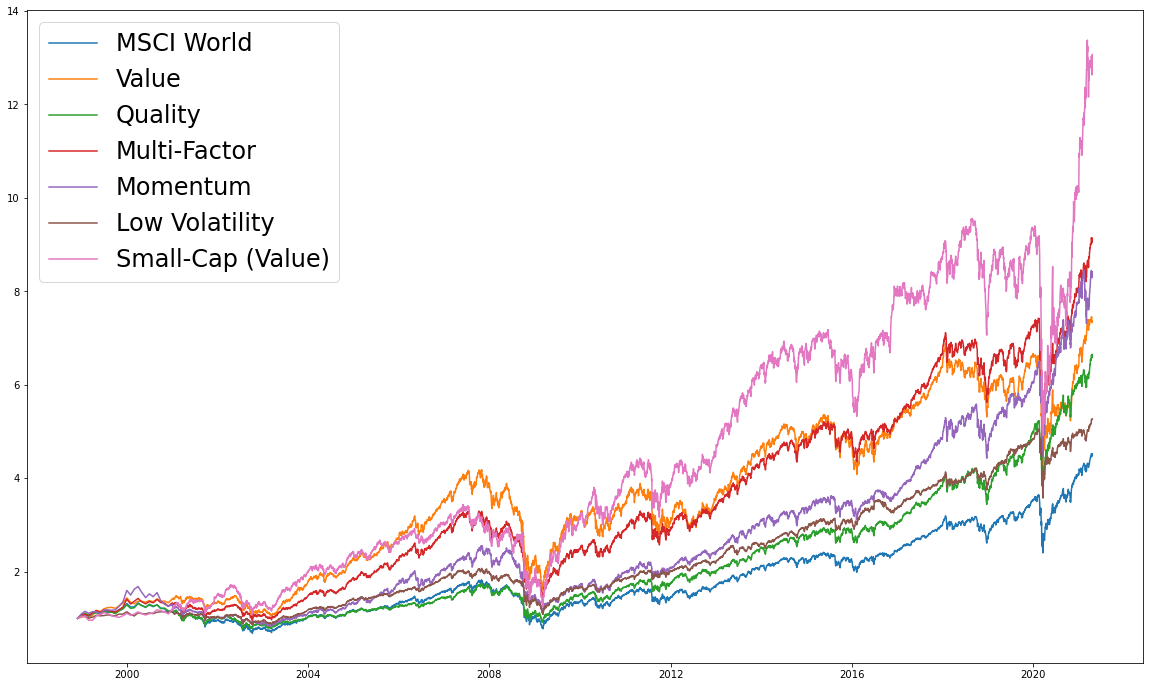

In [4]:
df = df.reset_index()
plt.figure(figsize=(20, 12))
for k in index_codes.keys():
    plt.plot(df["date"],df[k], label=k)
plt.legend(prop={'size':24})
plt.show()

We can see that all factors outperform the MSCI World.
We can also see that the two best running factors are Momentum and Small-Cap (Value).

Lets now calculate the factors for each of our indicies. The idea is, that the change of market price w.r.t to the risk free return can be descriped as 
\begin{equation}
    r_f = a \cdot MKT+b \cdot SMB +c \cdot HML+d \cdot RMW+e \cdot CMA
\end{equation}
The original Fama French paper knew a,b,c,d and e for a given portfolio (those are metrics like P/E), and deterimed the influence factors.
We do it the other way around. We know the influence factors from the paper and want to determine the 'sizeness' of an index (so we determine a,b,c,d,e).

In [5]:
factors = {}
fit_results = {}
for key in index_codes.keys():
    code = index_codes[key]["code"]
    print("calculating for ",code)
    fitted_factors, results, data = estimate(code,start_date=start_date,region=index_codes[key]["region"])
    factors[key] = fitted_factors
    fit_results[key] = results

calculating for  990100
calculating for  705130
calculating for  702787
calculating for  706536
calculating for  703755
calculating for  129896
calculating for  139249


Before we move forward, lets have a look at the quality of the fit:

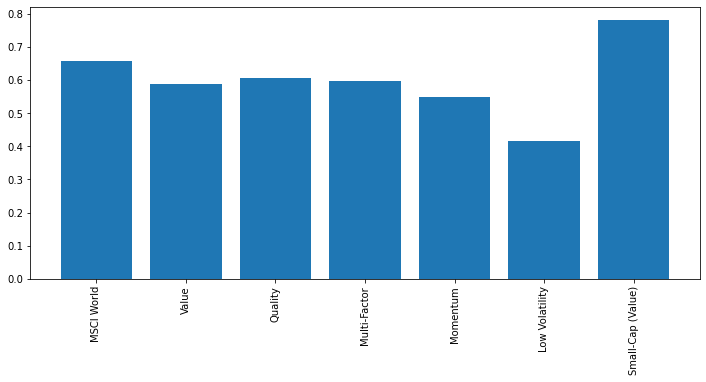

In [6]:
D={}
plt.figure(figsize=(12, 5))
for key in factors.keys():
    D[key] = fit_results[key].rsquared
plt.bar(*zip(*D.items()))
plt.xticks(rotation = 90)

plt.show()


From my perspective the r-squared value is relativily low.. The values of 0.4 are rather weak and maybe we should run further analysis here?
The original paper also quotes relativly low r² values. Maybe that's just normal?

We can also have a quick look at the global factorness of each index. Factorness is defined as
\begin{equation}
\phi = \sum_i f_i
\end{equation}
where $f_i$ is the individual factor. The key question of this analysis is if $\phi$ is the factor to optimize on or how to weight the individual contributions.

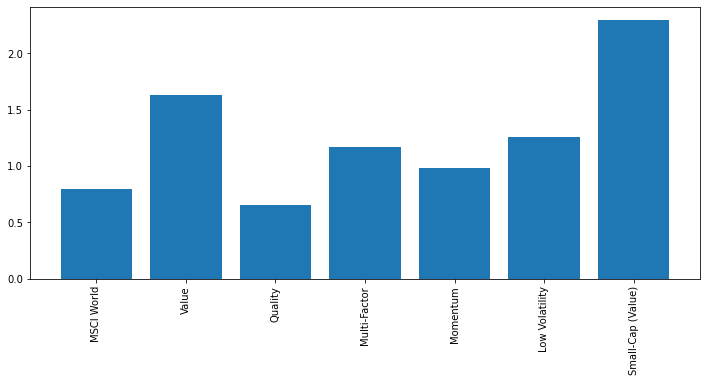

In [7]:
D={}
plt.figure(figsize=(12, 5))
for key in factors.keys():
    D[key] = factors[key].sum()
plt.bar(*zip(*D.items()))
plt.xticks(rotation = 90)
plt.show()

What we can see here is kind of telling. The Multi-Factor index is not outstanding! If the Mult-Factor index is clearly surperior we would have expected a high value here.
Let's look into the details and the individual factor for each of the 5 factors of the model:

<ipython-input-8-c540b212e669>:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


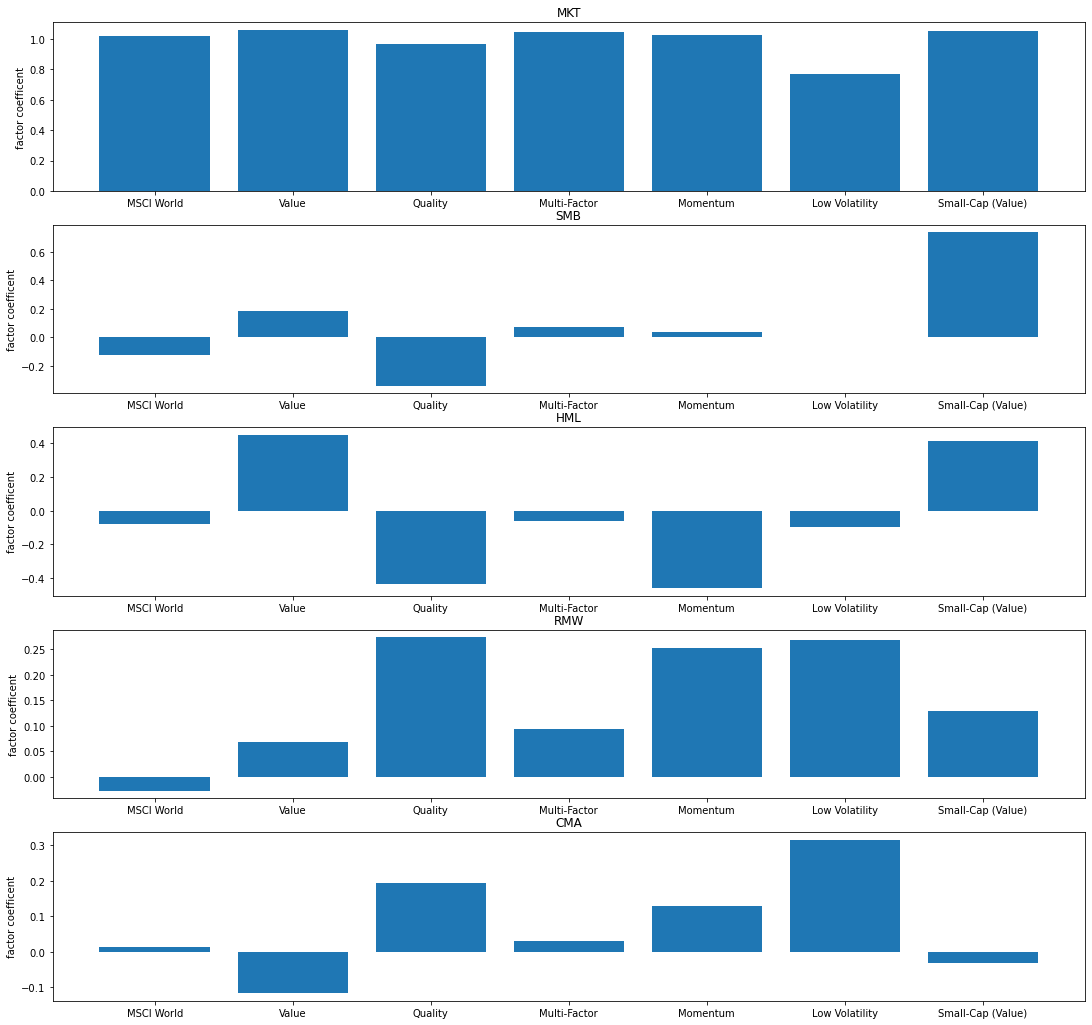

In [8]:
fig, axs = plt.subplots(5)
i = 0

for factorname in ["MKT","SMB","HML","RMW","CMA"]:
    D = {}
    for key in factors.keys():
        D[key] = factors[key][factorname]
    axs[i].bar(*zip(*D.items()))
    axs[i].set_title(factorname)
    #axs[i].set_ylim(-0.2,0.5)
    axs[i].set_ylabel("factor coefficent")
    i+=1
fig.set_size_inches(18.5, 18)
fig.show()

And for completness, lets look at it the other way around and see it grouped by the index:

<ipython-input-9-7ca36014792a>:18: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout()
<ipython-input-9-7ca36014792a>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


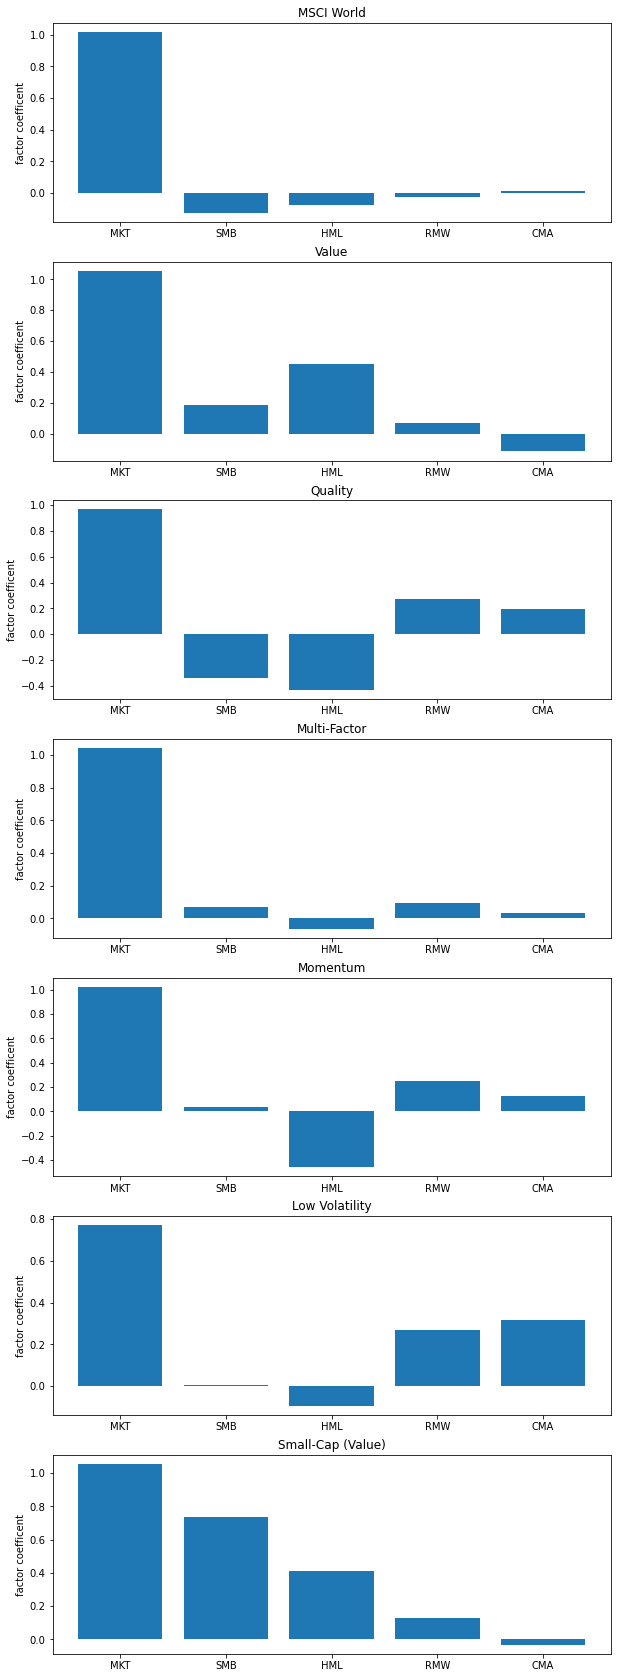

In [9]:
fig, ax = plt.subplots(len(index_codes))

width = 0.35  # the width of the bars
i = 0
for key in factors.keys():
    D = {}
    for factorname in ["MKT","SMB","HML","RMW","CMA"]:
        D[factorname] = factors[key][factorname]
        
    ax[i].bar(*zip(*D.items()),label=key)
    ax[i].set_title(key)
    #ax[i].set_ylim(-0.2,0.5)
    ax[i].set_ylabel("factor coefficent")
    i+=1
    


fig.tight_layout()
fig.set_size_inches(10, 30)
fig.show()

What can we learn from here? First: Small Cap (Value) seams to be a beast! It offers exposure to the market, SMB and HML! And it does not even have negative contributions to RMW and CMA. Wow! One needs to remind oneselve, that Small Cap (Value) only has a [single ETF](https://www.justetf.com/de-en/etf-profile.html?groupField=index&from=search&isin=IE00BSPLC413) in Germany which is relativly expensive (0.3% TER)

# Factor Exposure and Expected Returns for Mixtures

Lets move into the optimization. We first define our factor matrix

In [10]:
factor_matrix = pd.DataFrame.from_dict(factors).drop(["Intercept"],axis=0)

The factorness vector $\vec{f}$ can now be expressed as:
\begin{equation}
\vec{f} = \underline{F} \cdot \alpha
\end{equation}
Where $\underline{F}$ is the factor matrix and $\alpha$ our asset allocation vector.

**This boils down to the key open question: How to weight the different factors?** 

As an idea, lets take the average factor values from FF, scale them to a year and take them as a weightening factor. We can then just calculate the returns as:
\begin{equation}
    r = \vec{f} \cdot \vec{P}
\end{equation}
Where P holds the averages of the factors.

*Note: Maybe we want to take the monthly factor values here?*

*Note2: Just scaling it ignores the compound effect*

*Note3: The Small Cap Value is like a US ETF, so ideally one may want to use the higher US values here?*




In [11]:

index_names = df.columns.tolist()
index_names.remove("date")
numberOfIndecies = len(index_names)
def factorness(alpha):
  return factor_matrix.dot(alpha)

average_factors = get_average_factors("Developed")*252
def excess_returns(alpha):
    factors = factorness(alpha)
    returns = average_factors.dot(factors)
    return returns*100
asset_allocations = {} # this will hold all proposals for later loops etc

Lets now define a few portfolios which can be interesting for us

In [17]:
from asset_allocation import AssetAllocation

multi_factor_allocation = AssetAllocation(index_names)
multi_factor_allocation = multi_factor_allocation.set_allocation("Multi-Factor",1)
multi_factorness = factorness(multi_factor_allocation.to_array())
asset_allocations["Pure Multi"] = multi_factor_allocation

world_allocation = AssetAllocation(index_names)
world_allocation = world_allocation.set_allocation("MSCI World",1)
world_factorness = factorness(world_allocation.to_array())
asset_allocations["Pure World"] = world_allocation



small_value_momentum_allocation = AssetAllocation(index_names);
small_value_momentum_allocation.set_allocation("Small-Cap (Value)",0.4)
small_value_momentum_allocation.set_allocation("Momentum",0.2)
small_value_momentum_allocation.set_allocation("Value",0.4)

asset_allocations["Small-Value-Momentum"] = small_value_momentum_allocation

small_momentum_value_allocation = AssetAllocation(index_names);
small_momentum_value_allocation.set_allocation("Small-Cap (Value)",0.4)
small_momentum_value_allocation.set_allocation("Momentum",0.4)
small_momentum_value_allocation.set_allocation("Value",0.2)
asset_allocations["Small-Momentum-Value"] = small_momentum_value_allocation


small_quality_value_allocation = AssetAllocation(index_names);
small_quality_value_allocation.set_allocation("Small-Cap (Value)",0.4)
small_quality_value_allocation.set_allocation("Quality",0.2)
small_quality_value_allocation.set_allocation("Value",0.4)
small_quality_value_factorness = factorness(small_quality_value_allocation.to_array())
asset_allocations["Small-Quality-Value"] = small_quality_value_allocation

even_allocations = AssetAllocation(index_names)
even_allocations.set_allocation("Value",0.2)
even_allocations.set_allocation("Quality",0.2)
even_allocations.set_allocation("Momentum",0.2)
even_allocations.set_allocation("Low Volatility",0.2)
even_allocations.set_allocation("Small-Cap (Value)",0.2)
asset_allocations["Even Allocation"] = even_allocations

In [18]:
result_dict = {}
#print(asset_allocations.keys())
for key in asset_allocations.keys():
    result_dict[key] = {}
    factorness_vector = factorness(asset_allocations[key].to_array())
    result_dict[key]["factorness"] = float(factorness_vector.sum())
    result_dict[key]["returns"] = float(excess_returns(asset_allocations[key].to_array())[0])
    for name, value in zip(["MKT","SMB","HML","RMW","CMA"],factorness_vector[0]):
        result_dict[key][name] = value

    
result_df = pd.DataFrame(result_dict).T.sort_values("returns",ascending=False)
display(result_df)

factorness   returns       MKT       SMB       HML  \
Return Optimized        1.775066  7.344758  1.049504  0.376119  0.253368   
Small-Value-Momentum    1.775047  7.344751  1.049503  0.376116  0.253328   
Small-Quality-Value     1.709806  7.298817  1.037945  0.300292  0.258865   
Small-Momentum-Value    1.643954  7.179340  1.043043  0.347141  0.071387   
Even Allocation         1.370487  6.785255  0.974446  0.124610 -0.024821   
Pure Multi              1.176945  6.523625  1.043060  0.072543 -0.063378   
Pure World              0.800869  5.724774  1.017619 -0.124986 -0.078457   

                           RMW       CMA  
Return Optimized      0.129531 -0.033457  
Small-Value-Momentum  0.129547 -0.033447  
Small-Quality-Value   0.133641 -0.020936  
Small-Momentum-Value  0.166636  0.015746  
Even Allocation       0.198631  0.097621  
Pure Multi            0.093885  0.030835  
Pure World           -0.027644  0.014336

# Numerical Optimization for Returns
We can now try to use a numerical optimization in order to find the result which maximizes the total factorness $\phi$. One key thing here is, that we need to specifiy bonds. If not the optimizer will throw everything into Small Cap (Value), since it's a beast.
Lets define bounds as \[0, 0.4\] and lets also deactivate the use of multi factor:

In [19]:

from scipy.optimize import minimize
# objective function
def func(alpha):
    return -1*excess_returns(alpha)

# constraint: sum(weights) = 1
fconst = lambda w: 1 - sum(w)
cons   = ({'type':'eq','fun':fconst})

# initial weights
w0 =  np.ones((len(index_codes),1))/len(index_codes)

# define bounds
b    = (0.0, 0.4) 
bnds = [b for i in range(0,numberOfIndecies)]
bnds[3] = (0.0,0.0001)
# minimize
sol_returns  = minimize(func,
                w0,
                bounds      = bnds,
                constraints = cons)
print(sol_returns.fun*-1)
return_optimize_dict = {}
for alloc, name in zip(sol_returns.x,factor_matrix.columns):
    return_optimize_dict[name]=alloc

display(pd.DataFrame.from_records(return_optimize_dict,index=["allocation"]).round(decimals=2))
asset_allocations["Return Optimized"] = AssetAllocation(index_names).set_allocations(sol_returns.x)


mean    7.344758
dtype: float64


Low Volatility  MSCI World  Momentum  Multi-Factor  Quality  \
allocation             0.0         0.0       0.2           0.0      0.0   

            Small-Cap (Value)  Value  
allocation                0.4    0.4


It is somewhat funny to see, that the result of this longer analys
is is a bit the trivial solution of taking the 3 best running ones and mixing them. The reason for this is that we do not yet consider volatility nor diversification as a constraint for our optimization.


Even Allocation  Pure Multi  Pure World  Return Optimized  \
returns         1.060481    0.798852         0.0          1.619984   

         Small-Momentum-Value  Small-Quality-Value  Small-Value-Momentum  
returns              1.454566             1.574043              1.619977

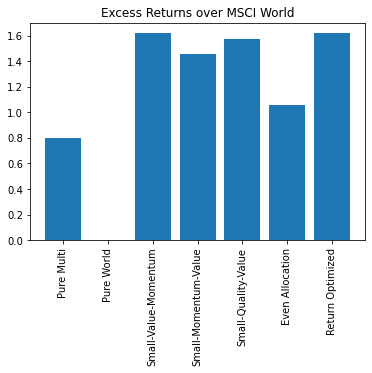

In [20]:
return_dict = {}
for key, value in asset_allocations.items():
    return_dict[key] = float(excess_returns(value.to_array()).iloc[0])
# normalize to MSCI World returns
pure_world_return = return_dict["Pure World"]
for key, value in return_dict.items():
    return_dict[key] = value-pure_world_return
    
display(pd.DataFrame.from_records(return_dict,index=["returns"]))
plt.bar(return_dict.keys(), return_dict.values())
plt.title("Excess Returns over MSCI World")
plt.xticks(rotation = 90)
plt.show()

In [21]:
from factor_estimator import create_index_of_indices
for key, value in asset_allocations.items():
    df = create_index_of_indices(df,key,value)


<Figure size 1440x864 with 0 Axes>

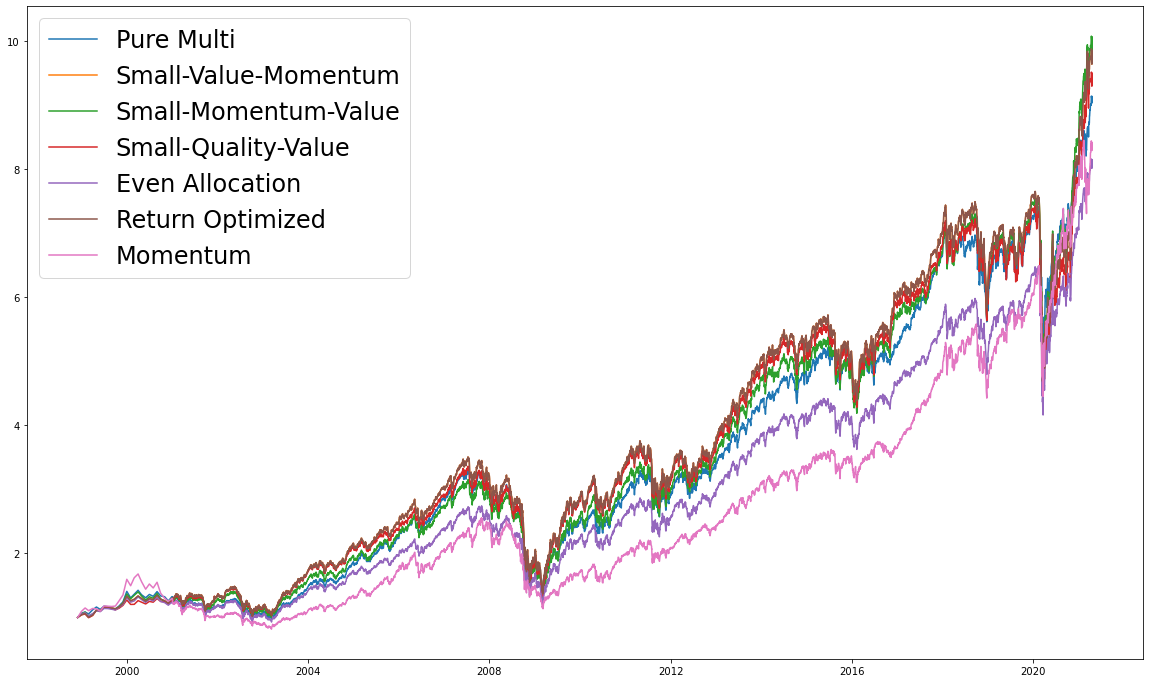

In [22]:
plt.figure(figsize=(20, 12))
allocs_to_show = [key for key in asset_allocations.keys()]
allocs_to_show.remove("Pure World")
allocs_to_show.append("Momentum")
plt.figure(figsize=(20, 12))

for k in allocs_to_show:
    plt.plot(df["date"],df[k], label=k)
#gfg = sns.lineplot(data = df[c])
plt.legend(prop={'size':24})
plt.show()


# Taking Volatility into Account

In [23]:
volatility_dict = {}
for key in asset_allocations.keys():
    volatility_dict[key] = df[key].pct_change().dropna().std()*100
display(pd.DataFrame.from_records(volatility_dict,index=["daily standard deviation"]))

Even Allocation  Pure Multi  Pure World  \
daily standard deviation         1.072533    1.068646    1.063847   

                          Return Optimized  Small-Momentum-Value  \
daily standard deviation          1.206968              1.217058   

                          Small-Quality-Value  Small-Value-Momentum  
daily standard deviation             1.214602              1.206968

In [24]:
from scipy.optimize import minimize
# objective function
regularizationFactor = 1
volatility_chart_dict = {}
def volatility(alpha):
    alloc = AssetAllocation(index_names)
    alloc.set_allocations(alpha)
    aux = create_index_of_indices(df,"aux",alloc)
    std_dev = df["aux"].pct_change().dropna().std()*100
    return std_dev

def func(alpha):
    return -1*excess_returns(alpha).sum()+regularizationFactor*volatility(alpha)
results = {}
for regularizationFactor in range(0,15):
    


    # constraint: sum(weights) = 1
    fconst = lambda w: 1 - sum(w)
    cons   = ({'type':'eq','fun':fconst})

    # initial weights
    w0 =  np.ones((len(index_codes),1))/len(index_codes)

    # define bounds
    b    = (0.0, .4) 
    bnds = [b for i in range(0,numberOfIndecies)]
    bnds[3] = (0.0,0.0001)
    # minimize
    sol  = minimize(func,
                    w0,
                    bounds      = bnds,
                    constraints = cons)

    optimized_allocation = AssetAllocation(index_names)
    optimized_allocation = optimized_allocation.set_allocations(sol.x)
#     print("### "+str(regularizationFactor)+" ###")
#     print(excess_returns(sol.x).sum(),"  /  ",volatility(sol.x))
#     print(optimized_allocation)
    results[regularizationFactor] = optimized_allocation.allocations
    results[regularizationFactor]["Returns"] = excess_returns(sol.x).sum()
    results[regularizationFactor]["Volatility"] = volatility(sol.x)

fit_results = pd.DataFrame.from_dict(results)
for c in fit_results.columns:
    fit_results[c] = fit_results[c].round(decimals=2)
display(fit_results)

# Add the volatility optimized allocation to our main data frame
volatility_allocation = AssetAllocation(index_names)
for name, alloc in results[10].items():
    if(name != "Returns" and name != "Volatility"):
        volatility_allocation.set_allocation(name, alloc)

asset_allocations["Volatility Optimized"] = volatility_allocation
df = create_index_of_indices(df,"Volatility Optimized",volatility_allocation)

comparison_dict = {"Pure World":{},"Pure Multi":{}}
comparison_dict["Pure World"]["Returns"] = float(excess_returns(asset_allocations["Pure World"].to_array()).sum())
comparison_dict["Pure World"]["Volatility"] = float(volatility(asset_allocations["Pure World"].to_array()))
comparison_dict["Pure Multi"]["Returns"] = float(excess_returns(asset_allocations["Pure Multi"].to_array()).sum())
comparison_dict["Pure Multi"]["Volatility"] = float(volatility(asset_allocations["Pure Multi"].to_array()))
comparison_df = pd.DataFrame.from_dict(comparison_dict)
display(comparison_df)

0     1     2     3     4     5     6     7     8     9   \
MSCI World         0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
Value              0.40  0.40  0.40  0.40  0.40  0.40  0.40  0.40  0.32  0.25   
Quality            0.00  0.00  0.00  0.00  0.00  0.00  0.03  0.05  0.16  0.26   
Multi-Factor       0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
Momentum           0.20  0.20  0.18  0.06  0.16  0.20  0.17  0.15  0.12  0.10   
Low Volatility     0.00  0.00  0.02  0.40  0.40  0.40  0.40  0.40  0.40  0.40   
Small-Cap (Value)  0.40  0.40  0.40  0.14  0.04  0.00  0.00  0.00  0.00  0.00   
Returns            7.34  7.34  7.34  6.84  6.71  6.65  6.64  6.64  6.54  6.46   
Volatility         1.21  1.21  1.20  1.01  0.97  0.96  0.96  0.96  0.94  0.93   

                     10    11    12    13    14  
MSCI World         0.00  0.00  0.00  0.00  0.00  
Value              0.20  0.17  0.15  0.13  0.13  
Quality            0.32  0.36  0.39  0.40  0.40  
Multi-Factor       0.00  0.00  0.00  0.00  0.00  
Momentum           0.08  0.07  0.07  0.07  0.07  
Low Volatility     0.40  0.40  0.40  0.40  0.40  
Small-Cap (Value)  0.00  0.00  0.00  0.00  0.00  
Returns            6.41  6.38  6.35  6.34  6.33  
Volatility         0.93  0.93  0.92  0.92  0.92

Pure World  Pure Multi
Returns       5.724774    6.523625
Volatility    1.063847    1.068646

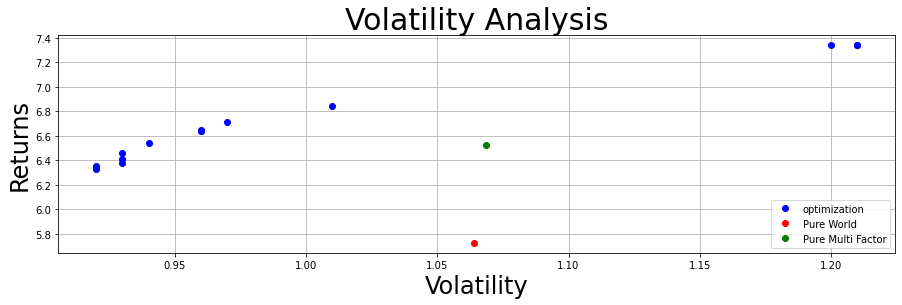

In [25]:
plot_df = fit_results.T[["Returns","Volatility"]]
plt.figure(figsize=(15, 4))
plt.title("Volatility Analysis",fontsize=30)
plt.xlabel("Volatility",fontsize=24)
plt.ylabel("Returns",fontsize=24)
plt.grid(True)

plt.plot(plot_df["Volatility"], plot_df["Returns"],'bo',label="optimization")
plt.plot(comparison_df.T["Volatility"][0], comparison_df.T["Returns"][0],'ro',label="Pure World")
plt.plot(comparison_df.T["Volatility"][1], comparison_df.T["Returns"][1],'go',label="Pure Multi Factor")
plt.legend(loc="lower right")
plt.show()

What can we learn from here? Well, we have a few interesting portfolios i think:

## The High Risk High Return Portfolio:
Thats the top right. It is
* 40% Small Cap (Value)
* 40% Value
* 20% Momentum
This gives you roughly 7.35% returns or 1.6% gain over the MSCI World. You pay for it with higher Volatility. 

## The Low Volatility
Thats on the lower left (there are a few, thats the "10")::
* 33% Low Volatility
* 10% Momentum
* 32% Quality
* 18% Value

You can get a roughly 6.5% return (remember, this is compared to US Treasury bonds). Which is 0.7% gain over the MSCI World or roughly the same as the Multi-Factor. 

# Looking into Volatility

For now, we will focus on the 'High Rish High Return Portfolio". How well did it run for the past years? Those cummulated plots above are nice to look at, because you mostly on top of the MSCI World curve, but it hides a bit the variability of the factor. Lets there fore look at the comparison to the MSCI World. When would we be worse or better off than the MSCI World?
To do this we have a look at:
\begin{equation}
 r = MA(\%\text{Change}(\text{daily_returns}))_{x} -MA(\%\text{Change}(\text{daily_returns}))_{MSCI World}
\end{equation}
Where MA is the moving average and %Change is the percent change to the day before.

Let's first have a look at the charts for the 'normal Factors' and then for our allocations

<Figure size 1440x864 with 0 Axes>

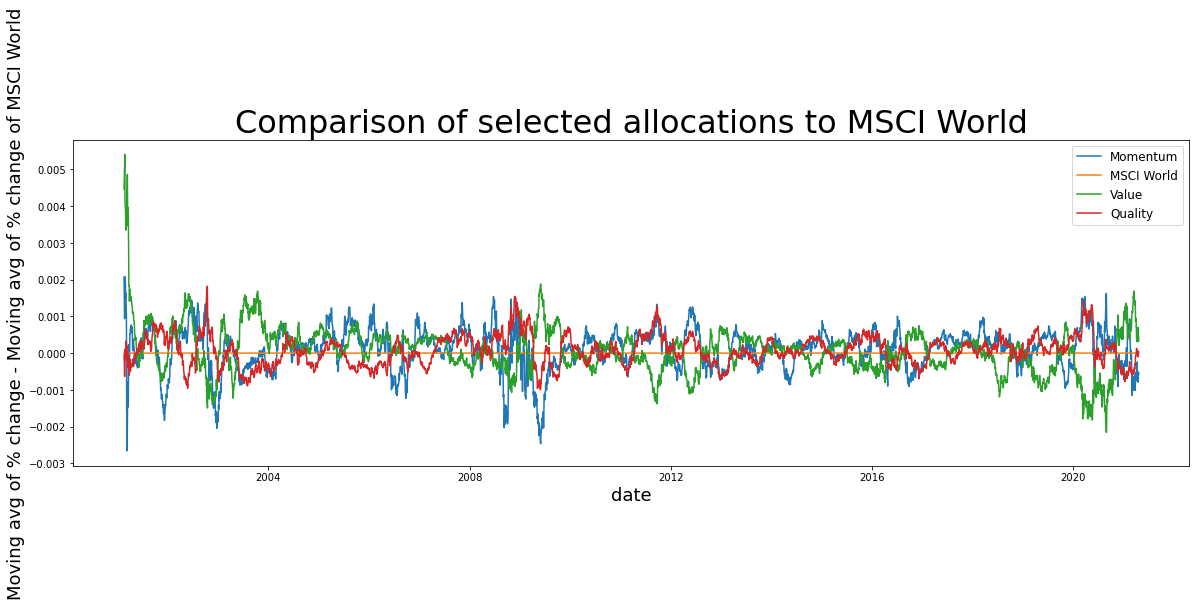

In [26]:
plt.figure(figsize=(20, 12))
allocs_to_show = []
allocs_to_show.append("Momentum")
allocs_to_show.append("MSCI World")
allocs_to_show.append("Value")
allocs_to_show.append("Quality")
plt.figure(figsize=(20, 6))
window_size = 60
for k in allocs_to_show:
    plt.plot(df['date'],df[k].pct_change().rolling(window_size).mean()-df["MSCI World"].pct_change().rolling(window_size).mean(),label=k)
plt.legend(prop={'size':12})
plt.xlabel('date', fontsize=18)
plt.ylabel('Moving avg of % change - Moving avg of % change of MSCI World', fontsize=18)
plt.title("Comparison of selected allocations to MSCI World",fontsize=32)
plt.show()


<Figure size 1440x864 with 0 Axes>

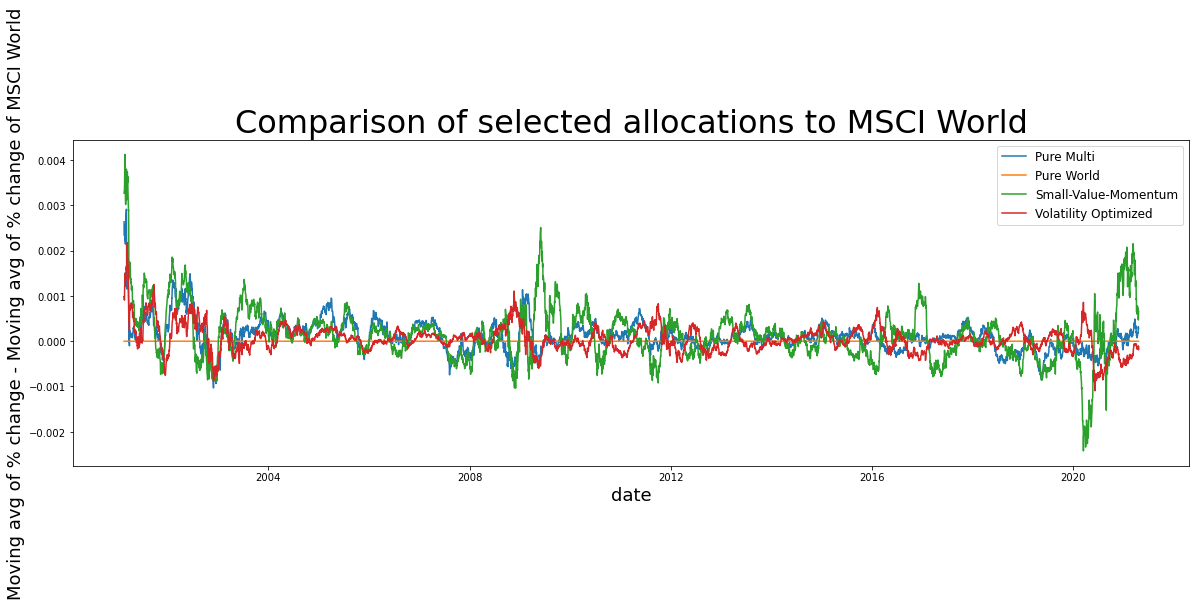

In [27]:
plt.figure(figsize=(20, 12))
allocs_to_show = [key for key in asset_allocations.keys()]

allocs_to_show.remove("Even Allocation")
allocs_to_show.remove("Small-Quality-Value")
allocs_to_show.remove("Return Optimized")
allocs_to_show.remove("Small-Momentum-Value")

plt.figure(figsize=(20, 6))
window_size = 60
for k in allocs_to_show:
    plt.plot(df['date'],df[k].pct_change().rolling(window_size).mean()-df["MSCI World"].pct_change().rolling(window_size).mean(),label=k)
plt.legend(prop={'size':12})
plt.xlabel('date', fontsize=18)
plt.ylabel('Moving avg of % change - Moving avg of % change of MSCI World', fontsize=18)
plt.title("Comparison of selected allocations to MSCI World",fontsize=32)
plt.show()

## Value and Volatility Lessons
What we can learn from here, is that there will be always times where a given factor under performs the market. This is totally normal and it *has* to happen. Why? For more returns we get more volatility. More volatility means we are sometimes below the MSCI World, which is less volatile. Thats the point!

If you look at the Value premium in our first chart you can see that it had a hard time in the time after 2016. Its very well known that Value investing was problematic over the past years. Is that a reason to abondon value?

Fama and French show in their 2018 paper [Volatility Lessons](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3081101), that it is totally normal that a factor under performs for 5 years. Their analysis, where there bootstrap themselves a lot of pseudo-dataset, they showed that a 5 year underperformance of a factor is nothing rare. Even a 10 year underperformance is not impossible.

Another great paper on the topic is [Reports of Value’s Death May Be Greatly Exaggerated](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3488748). The authors come to the same conclusion as FF above, saying that the recent 'slump' is a strong statistical abnormally, but in 2.5% of their bootstrapped samples they expirienced a similar or worse situation.
The authors also show, that most of the arguments by 'Death-Callers' are easily refutable. They however say, that P/E is a bad ratio to start with and that there are some problems with high investments into R&D, which are likely not covered by earnings.

We will always see 'finance pornographs' call a factor dead. But as factor investors we need to make ourselves aware, that (to the best of my knowledge), there is no statistical evidence for this. This is in my opinion the pain you need to go throw, to get the better returns.


# The Momentum Value Trade Off

Our analysis showed, that it may be very intersting to invest into momentum and value at the same time. After doing the analysis I saw the paper [Value and Momentum everywhere](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1363476), which supports this idea. I would definitly advise you to read it, here are two short quotes from the conclusion:
*Value and momentum deliver positive expected abnormal returns in a variety of markets and  asset  classes,  their  combination  performs  even  better  than  either  alone,  and  the  benefits of diversification across markets and asset classes are large*

and

*We find that value (and momentum) strategies are positively related across markets and asset  classes  and  that  value  and  momentum  are  negatively  related  within  and  across  markets  and  asset  classes*

The paper also shows a negative correlation between momentum and value (see Table 1), which is desirable. If two factors are negativly correlated with one another, then they cover for the other when the other is week. Thus you get a more steady total return curve and hopefully it is then easier to stay invested.

# 20% Momentum? Or more?

So, we setteled down to a portfolio with 40% Small Cap (Value) and the rest is Momentum and Value. The optimization yielded 40% Value and 20% Momentum.
The question is: Is that correct?

Lets therefore look at two charts.
* 1. The raw delta between the 40% Value and other allocations
* 2. The same metric we used enough, the moving average in change of daily gains in percent.


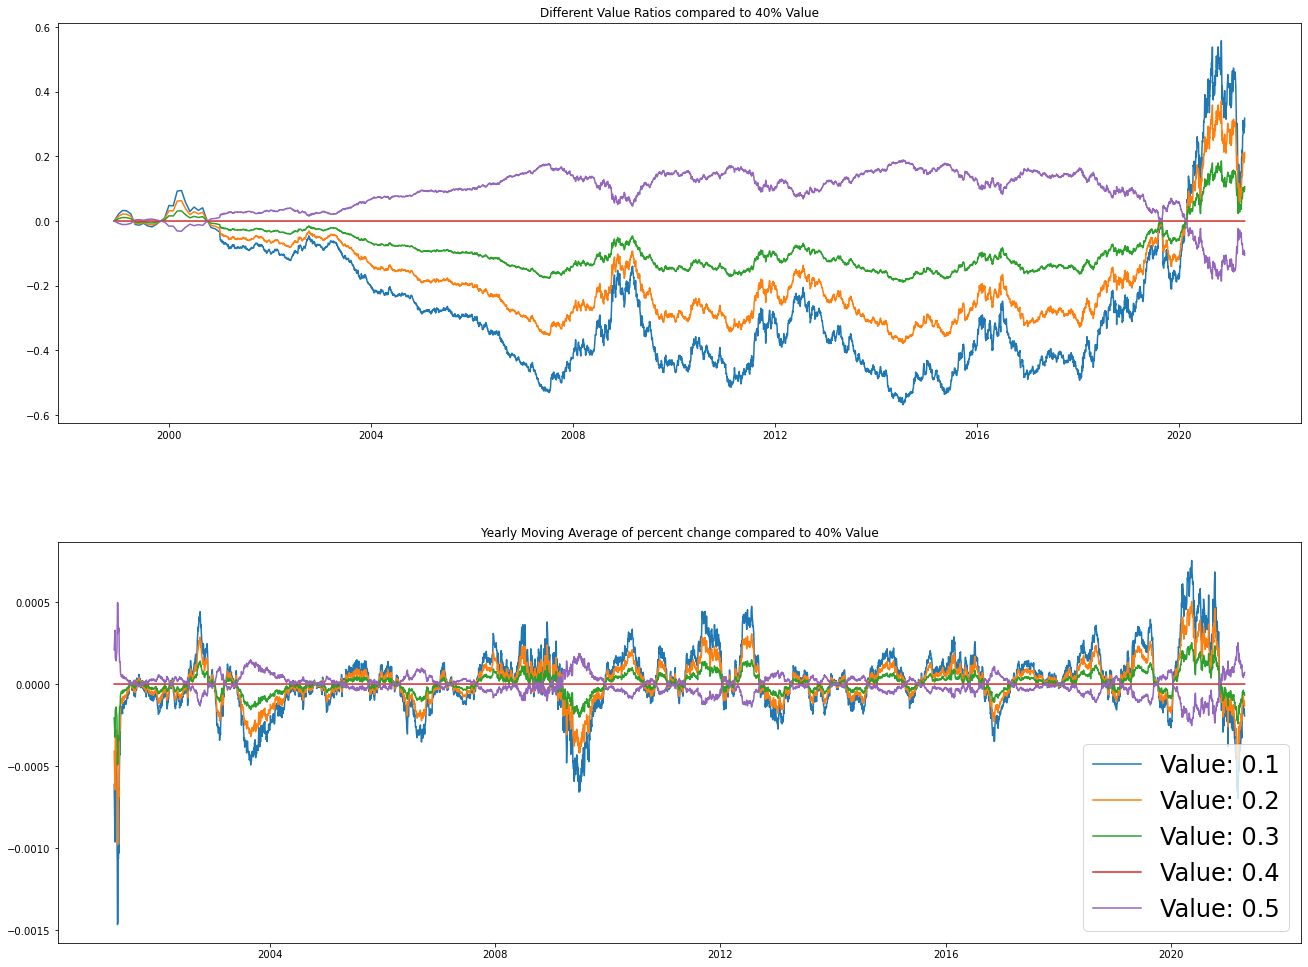

In [28]:
momentum_df = df[["date","Small-Value-Momentum"]]

m_alloc = AssetAllocation(index_names)
m_alloc.set_allocation("Small-Cap (Value)",0.4)

fig, ax = plt.subplots(2)

fig.tight_layout()
fig.set_size_inches(20, 15)
window_size = 90
for value_alloc in [0.1,0.2,0.3,0.4,0.5]:
    m_alloc.set_allocation("Value",value_alloc)
    m_alloc.set_allocation("Momentum",0.6-value_alloc)
    name = "Value: "+str(value_alloc)

    momentum_df.loc[:,name] = create_index_of_indices(df,name,m_alloc).loc[:,name]
    momentum_df[name+"_relative"] =  momentum_df[name].pct_change().rolling(window_size).mean() - df["Small-Value-Momentum"].pct_change().rolling(window_size).mean()

    ax[0].plot(momentum_df['date'],momentum_df[name]-df["Small-Value-Momentum"],label=name)
    ax[1].plot(momentum_df['date'],momentum_df[name+"_relative"],label=name)
ax[0].set_title("Different Value Ratios compared to 40% Value")
ax[1].set_title("Yearly Moving Average of percent change compared to 40% Value")
plt.legend(prop={'size':24})#
plt.show()


What can we learn from here? For a long long time it would hav eeen beneficial to go in with as much value as possible. Only in 2018 forward Momentum 'kicked back' and is now, even in total, on top.
The problem I see here is the sample bias problem. In the end we only work on 22 years of data. If - by accident - the first 15 of them where strong value years our strategy is directled towards more value then it would be good over all. 

# Holding Analysis

In [31]:
holding_indices = indexHandler.available_indices
data = []
index_names = [ key for key in holding_indices.keys()]
spdr = None
for key in holding_indices:
    if(holding_indices[key]["vendor"] == "Xtrackers"):
        data.append(get_xtrackers(holding_indices[key]["ISIN"],key))
    if(holding_indices[key]["vendor"] == "SPDR"):
        data.append(get_spdr(holding_indices[key]["ticker"],key))
    if (holding_indices[key]["vendor"] == "iShares"):
        #print("Will not read ",key,"iShares is annoying")
        #does not work yet, isharse names INTEL as INTEL Corp etc -.-
        data.append(get_iShares(key,key))
        

holding_df = data[0]
for i in range(1,len(data)):
    #print(data[i])
    holding_df = holding_df.merge(data[i], how='outer',left_on="ISIN",right_on="ISIN",suffixes=('', '_DROP'))
    holding_df["Name"].fillna(holding_df["Name_DROP"], inplace=True)
    holding_df["Country"].fillna(holding_df["Country_DROP"], inplace=True)
    holding_df["Industry Classification"].fillna(holding_df["Industry Classification_DROP"], inplace=True)
    holding_df = holding_df.fillna(0).filter(regex='^(?!.*_DROP)')

C:\Users\MartinSchmitz\Anaconda3\envs\factornessy\lib\site-packages\openpyxl\styles\stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


## Top Holdings

In [32]:
chosen_allocation = AssetAllocation(index_names)
chosen_allocation.set_allocation("Momentum",0.2)
chosen_allocation.set_allocation("Value",0.4)
chosen_allocation.set_allocation("Small-Cap (Value)",0.4)
holding_df = create_index_of_indices(holding_df, "Small-Value-Momentum", chosen_allocation)


holding_df = holding_df.sort_values("Small-Value-Momentum",ascending=False)
display(holding_df[["Name","Small-Value-Momentum"]].head(50))

Name  Small-Value-Momentum
21                       INTEL              0.019320
6                 TESLA MOTORS              0.011342
31                        AT&T              0.010874
1                    MICROSOFT              0.010569
0                        APPLE              0.009746
104          MICRON TECHNOLOGY              0.009681
2                       AMAZON              0.009277
79                         IBM              0.008289
49                      TOYOTA              0.007558
3                     FACEBOOK              0.007132
11                      NVIDIA              0.006927
67           SOFTBANK GR.CORP.              0.006289
121          BRIT.AMER.TOBACCO              0.005955
42                 BROADCOM RG              0.005721
5                   ALPHABET C              0.005684
4                   ALPHABET A              0.005644
254                    HITACHI              0.005282
30                      PFIZER              0.005220
29                       CISCO              0.005113
40                      ABBVIE              0.004905
19                      PAYPAL              0.004600
101                 CVS HEALTH              0.004339
64                   CITIGROUP              0.004092
151             GENERAL MOTORS              0.004039
298                ITOCHU CORP              0.003957
138                    DAIMLER              0.003866
62         BRISTOL MYERS SQUIB              0.003836
215             VOLKSWAGEN VZ.              0.003753
2000     GAMESTOP CORP CLASS A              0.003651
115                      CIGNA              0.003579
253            HEWLETT-PACKARD              0.003557
358                 MITSUBISHI              0.003403
85                      SANOFI              0.003325
372                MITSUI & CO              0.003295
23                       ADOBE              0.003286
347           STELLANTIS BR RG              0.003229
346           STELLANTIS BR RG              0.003229
2011                KOHLS CORP              0.003118
238                      HONDA              0.003062
177                      BAYER              0.003030
41    THERMO FISHER SCIENTIFIC              0.003029
157                BNP PARIBAS              0.003006
174     MITSUBISHI TOKYO FINL.              0.002982
3106                 MACYS INC              0.002972
236                   VODAFONE              0.002931
120                     ALTRIA              0.002823
471                      ENGIE              0.002821
105                     ANTHEM              0.002703
55                     DANAHER              0.002645
127            GILEAD SCIENCES              0.002630

In [33]:
grouped = holding_df.groupby("Industry Classification").sum()
grouped = grouped.reset_index()
grouped["Industry Classification"][grouped["Small-Value-Momentum"] <0.01] = "Other"
#print(grouped)
fig = px.pie(grouped, values='Small-Value-Momentum', names='Industry Classification')
fig.show()

In [34]:
grouped = holding_df.groupby("Country").sum()
grouped = grouped.reset_index()
grouped["Country"].loc[grouped["Small-Value-Momentum"] <0.01] = "Other"
#print(grouped)
fig = px.pie(grouped, values='Small-Value-Momentum', names='Country')
fig.show()

# The European Question


# Known Drawbacks - Limitations and FAQ

## The data is only back to 1998

## Isn't Value dead?

## Value has a lot of crap in it

## Small Cap Value's highest holding is GME - isn't that crazy?

## What about Emerging Markets?

## There is only this single SPDR Small Cap Value ETF - isn't it any good?

## What about High Dividends?

